In [1]:
import numpy as np
from scipy.integrate import solve_ivp, OdeSolver
import matplotlib.pyplot as plt
from joblib import load

import os, sys
# local modules
directory_to_prepend = os.path.abspath("../../src")
if directory_to_prepend not in sys.path:
    sys.path = [directory_to_prepend] + sys.path

from utils.utils import get_median_from_experiment, get_summary
from utils.swim import backward 
from hamiltonians.double_pendulum import DoublePendulum
from error_functions.index import l2_error, l2_error_relative, mean_squared_error, mean_absolute_error
from utils.grid import generate_grid
from utils.plot import plot_ground_truth_trajectory_4d, plot_poincare, plot_predicted_trajectory_errors, plot_predicted_trajectory_energy, plot_predicted_trajectories_4d

EXPERIMENT_DIR = '../../old_cluster/out/main/double_pendulum/random/345744/combined_345744.pkl'

# load experiment
experiment = load(EXPERIMENT_DIR)
print(f"-> LOADED EXPERIMENT: {EXPERIMENT_DIR}")
print(f"                      {experiment.keys()} ")
print(f"                      n_runs = {len(experiment['runs'])} ")
print(f"                      single run includes keys: {experiment['runs'][0].keys()}")
print(f"-> SUMMARY:\n{get_summary(experiment, ['ELM', 'U-SWIM', 'A-SWIM', 'SWIM'], ['test'], ['errors'], ['l2_error_relative'], ['median', 'mean'])}")
print(f"-> ")
print(f"-> ELM bias min: {np.min(experiment['runs'][0]['ELM'][0].biases)}, max: {np.max(experiment['runs'][0]['ELM'][0].biases)}")

domain_params = experiment['domain_params']
H = experiment['domain_params']['H']
dH = experiment['domain_params']['dH']

print(f"-> DOMAIN PARAMS: {domain_params}")
elm_params = experiment['elm_params']
uswim_params = experiment['uswim_params']
aswim_params = experiment['aswim_params']
swim_params = experiment['swim_params']

print(f"-> ELM PARAMS: {elm_params}")
print(f"-> USWIM PARAMS: {uswim_params}")
print(f"-> ASWIM PARAMS: {aswim_params}")
print(f"-> SWIM PARAMS: {swim_params}")

elm_median_error, _, _, ELM = get_median_from_experiment(EXPERIMENT_DIR, 'ELM', error_function='l2_error_relative') 
uswim_median_error, _, _, USWIM = get_median_from_experiment(EXPERIMENT_DIR, 'U-SWIM', error_function='l2_error_relative') 
aswim_median_error, _, _, ASWIM = get_median_from_experiment(EXPERIMENT_DIR, 'A-SWIM', error_function='l2_error_relative') 
swim_median_error, _, _, SWIM = get_median_from_experiment(EXPERIMENT_DIR, 'SWIM', error_function='l2_error_relative') 

print(f"-> MEDIAN ERRORS")
print(f"- ELM:    {elm_median_error}")
print(f"- U-SWIM: {uswim_median_error}")
print(f"- A-SWIM: {aswim_median_error}")
print(f"- SWIM:   {swim_median_error}")

-> LOADED EXPERIMENT: ../../old_cluster/out/main/double_pendulum/random/345744/combined_345744.pkl
                      dict_keys(['domain_params', 'elm_params', 'uswim_params', 'aswim_params', 'swim_params', 'runs']) 
                      n_runs = 100 
                      single run includes keys: dict_keys(['train_random_seed', 'test_random_seed', 'model_random_seed', 'train_errors', 'train_losses', 'test_errors', 'test_losses', 'train_times', 'ELM', 'U-SWIM', 'A-SWIM', 'SWIM'])
-> SUMMARY:
test errors median (l2_error_relative)
- ELM   	: 0.005111184858818691
- U-SWIM   	: 0.004915407760835402
- A-SWIM   	: 0.004616700101888091
- SWIM   	: 0.004621479887736945
test errors mean (l2_error_relative)
- ELM   	: 0.005906127505125595
- U-SWIM   	: 0.011984753100526798
- A-SWIM   	: 0.011898067892630626
- SWIM   	: 0.009391102002928106
-> 
-> ELM bias min: -3.138702471076694, max: 3.1396375034876436
-> DOMAIN PARAMS: {'system_name': 'double_pendulum', 'H': <bound method DoublePendulum.

# **Ground Truth**

q1_plot_range shape (42,)
q2_plot_range shape (42,)
p1_plot_range shape (14,)
p2_plot_range shape (14,)
q1_plot_grid shape (42, 42, 14, 14)
q2_plot_grid shape (42, 42, 14, 14)
p1_plot_grid shape (42, 42, 14, 14)
p2_plot_grid shape (42, 42, 14, 14)


<Figure size 640x480 with 0 Axes>

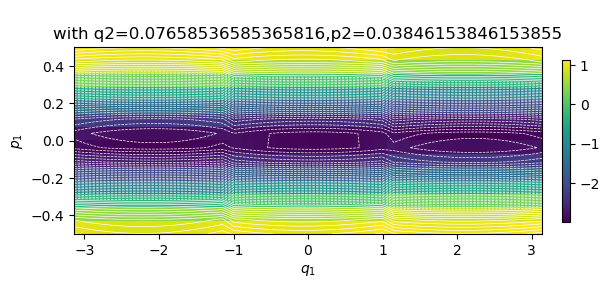


lim for q1: [-3.14, 3.14]
lim for q2: [-3.14, 3.14]
lim for p1: [-0.5, 0.5]
lim for p2: [-0.5, 0.5]


<Figure size 640x480 with 0 Axes>

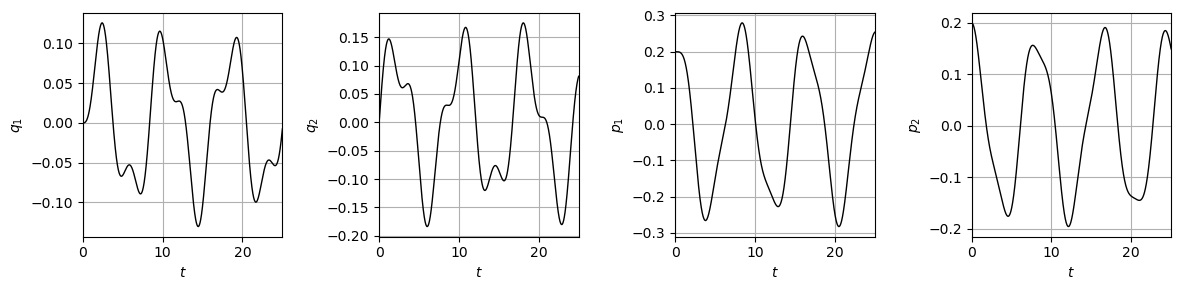

<Figure size 640x480 with 0 Axes>

In [2]:
#domain_params['q_test_lim'] = [[-6.28, 6.28]]
#domain_params['p_test_lim'] = [[-6, 6]]

def plot_poincares(H, domain_params, title, save=False, verbose=True):
    # WE PLOT POINCARE SECTION OF q1 AND p1 AND FIX q2 AND p2 TO ZERO
    N_q1 = N_p1 = domain_params['q_test'][0], domain_params['p_test'][0]
    N_q2 = N_p2 = domain_params['q_test'][1], domain_params['p_test'][1]
    q1_lim = p1_lim = domain_params['q_test_lim'][0], domain_params['p_test_lim'][0]
    q2_lim = p2_lim = domain_params['q_test_lim'][1], domain_params['p_test_lim'][1]

    [q1_range, q2_range], [p1_range, p2_range], q_grids, p_grids = generate_grid(domain_params['q_test'], domain_params['p_test'], 
                                                                                 domain_params['q_test_lim'], domain_params['p_test_lim'], dof=2, linspace=True)
    x = np.column_stack([ q_grid.flatten() for q_grid in q_grids ] + [ p_grid.flatten() for p_grid in p_grids ])

    # for this example we plot q1 and p1 and fix q2 and p2 at 0
    y_hat = H(x).reshape(-1)
    y = domain_params["H"](x).reshape(-1)
    plot_poincare(y_hat.reshape((N_q2, N_q1, N_p1, N_p2))[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_range, p1_range, [q1_lim[0],q1_lim[1],p1_lim[0],p1_lim[1]], 50, "q1", "p1", 1, 
                  title, { "q2": q2_range[N_q2//2], "p2": p2_range[N_p2//2] }, save=save, verbose=verbose)

    # error plot
    plot_poincare((y-y_hat).reshape((N_q2, N_q1, N_p1, N_p2))[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_range, p1_range, [q1_lim[0],q1_lim[1],p1_lim[0],p1_lim[1]], 50, "q1", "p1", 1, 
                  "ERROR"+title, { "q2": q2_range[N_q2//2], "p2": p2_range[N_p2//2] }, save=save, verbose=verbose)

N_q1, N_p1 = domain_params['q_test'][0], domain_params['p_test'][0]
N_q2, N_p2 = domain_params['q_test'][1], domain_params['p_test'][1]
q1_lim, p1_lim = domain_params['q_test_lim'][0], domain_params['p_test_lim'][0]
q2_lim, p2_lim = domain_params['q_test_lim'][1], domain_params['p_test_lim'][1]

[q1_plot_range, q2_plot_range], [p1_plot_range, p2_plot_range], q_plot_grids, p_plot_grids = generate_grid(domain_params['q_test'], domain_params['p_test'],
                                                                                                           domain_params['q_test_lim'], domain_params['p_test_lim'], dof=2, linspace=True)
print(f'q1_plot_range shape {q1_plot_range.shape}')
print(f'q2_plot_range shape {q2_plot_range.shape}')
print(f'p1_plot_range shape {p1_plot_range.shape}')
print(f'p2_plot_range shape {p2_plot_range.shape}')
print(f'q1_plot_grid shape {q_plot_grids[0].shape}')
print(f'q2_plot_grid shape {q_plot_grids[1].shape}')
print(f'p1_plot_grid shape {p_plot_grids[0].shape}')
print(f'p2_plot_grid shape {p_plot_grids[1].shape}')

x = np.column_stack([ q_grid.flatten() for q_grid in q_plot_grids ] + [ p_grid.flatten() for p_grid in p_plot_grids ])
y = H(x).reshape((N_q2, N_q1, N_p1, N_p2))

# plot q1 and p1 and fix q2 and p2 at 0
plot_poincare(y[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_plot_range, p1_plot_range, q1_lim + p1_lim, 50, r'$q_1$', r'$p_1$', 2.5, 
             '', { "q2": q2_plot_range[N_q1//2], "p2": p2_plot_range[N_p2//2] }, save='double_pendulum_ground_truth_phase.pdf', verbose=True)

def dt_true(t, x): 
    """
    ground truth time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_true = dH(x).T.reshape(-1)
    #print("dH is:", str(dH))
    return [dH_true[2], dH_true[3], -dH_true[0], -dH_true[1]] # [dH/dp1, dH/dp2, -dH/dq1, -dH/dq2] = [q1^dot, q2^dot, p1^dot, p2^dot]


# RK45
t_span = [0, 25] 
t_eval = np.linspace(t_span[0], t_span[1], 250000)
y0 = [0, 0, 0.2, 0.2]
#y0 = [np.pi/2, np.pi/2, 0, 0]   JAKOVAC
#y0 = [np.pi*3/7, np.pi*3/8, 0, 0] CHEN


motion_true = solve_ivp(dt_true, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-13)
# get integrated trajectories of shape (N,2)
traj_true = motion_true.y.T

q1_train_lim_start = experiment['domain_params']['q_train_lim'][0][0]
q1_train_lim_end = experiment['domain_params']['q_train_lim'][0][1]
q2_train_lim_start = experiment['domain_params']['q_train_lim'][1][0]
q2_train_lim_end = experiment['domain_params']['q_train_lim'][1][1]
p1_train_lim_start = experiment['domain_params']['p_train_lim'][0][0]
p1_train_lim_end = experiment['domain_params']['p_train_lim'][0][1]
p2_train_lim_start = experiment['domain_params']['p_train_lim'][1][0]
p2_train_lim_end = experiment['domain_params']['p_train_lim'][1][1]
print(f"lim for q1: [{q1_train_lim_start}, {q1_train_lim_end}]")
print(f"lim for q2: [{q2_train_lim_start}, {q2_train_lim_end}]")
print(f"lim for p1: [{p1_train_lim_start}, {p1_train_lim_end}]")
print(f"lim for p2: [{p2_train_lim_start}, {p2_train_lim_end}]")
if np.any(traj_true[:,0] < q1_train_lim_start):
    #TODO: error print: print("\x1b[31m\"red\"\x1b[0m")
    print(f"\x1b[31m\"WARNING: found q1={np.min(traj_true[:,0])}, which is out of bounds for this experiment\"\x1b[0m")
elif np.any(traj_true[:,0] > q1_train_lim_end):
    print(f"WARNING: found q1={np.max(traj_true[:,0])}, which is out of bounds for this experiment")
if np.any(traj_true[:,1] < q2_train_lim_start):
    print(f"WARNING: found q2={np.min(traj_true[:,1])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,1] > q2_train_lim_end):
    print(f"WARNING: found q2={np.max(traj_true[:,1])}, which is out of bounds for this experiment")
if np.any(traj_true[:,2] < p1_train_lim_start):
    print(f"WARNING: found p1={np.min(traj_true[:,2])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,2] > p1_train_lim_end):
    print(f"WARNING: found p1={np.max(traj_true[:,2])}, which is out of bounds for this experiment")
if np.any(traj_true[:,3] < p2_train_lim_start):
    print(f"WARNING: found p2={np.min(traj_true[:,3])}, which is out of bounds for this experiment")
elif np.any(traj_true[:,3] > p2_train_lim_end):
    print(f"WARNING: found p2={np.max(traj_true[:,3])}, which is out of bounds for this experiment")
    
plot_ground_truth_trajectory_4d(t_span, t_eval, traj_true, save='./double_pendulum_ground_truth_trajectories.pdf', verbose=True, linewidth=1)

# **Predictions**

In [3]:
# phase
#y = ELM.transform(x).reshape((N_q2, N_q1, N_p1, N_p2))
# plot q1 and p1 and fix q2 and p2 at 0
#plot_poincare(y[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_plot_range, p1_plot_range, q1_lim + p1_lim, 50, r'$q_1$', r'$p_1$', 2.5, 
#             '', { "q2": q2_plot_range[N_q1//2], "p2": p2_plot_range[N_p2//2] }, save='double_pendulum_ELM_phase.pdf', verbose=True)
#y = USWIM.transform(x).reshape((N_q2, N_q1, N_p1, N_p2))
# plot q1 and p1 and fix q2 and p2 at 0
#plot_poincare(y[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_plot_range, p1_plot_range, q1_lim + p1_lim, 50, r'$q_1$', r'$p_1$', 2.5, 
#             '', { "q2": q2_plot_range[N_q1//2], "p2": p2_plot_range[N_p2//2] }, save='double_pendulum_USWIM_phase.pdf', verbose=True)
#y = ASWIM.transform(x).reshape((N_q2, N_q1, N_p1, N_p2))
# plot q1 and p1 and fix q2 and p2 at 0
#plot_poincare(y[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_plot_range, p1_plot_range, q1_lim + p1_lim, 50, r'$q_1$', r'$p_1$', 2.5, 
#             '', { "q2": q2_plot_range[N_q1//2], "p2": p2_plot_range[N_p2//2] }, save='double_pendulum_ASWIM_phase.pdf', verbose=True)
# phase
#y = SWIM.transform(x).reshape((N_q2, N_q1, N_p1, N_p2))
# plot q1 and p1 and fix q2 and p2 at 0
#plot_poincare(y[N_q2//2, :, :, N_p2//2].reshape(N_p1, N_q1), q1_plot_range, p1_plot_range, q1_lim + p1_lim, 50, r'$q_1$', r'$p_1$', 2.5, 
#             '', { "q2": q2_plot_range[N_q1//2], "p2": p2_plot_range[N_p2//2] }, save='double_pendulum_SWIM_phase.pdf', verbose=True)

def dt_pred_elm(t, x):
    """
    ELM
    predicted time derivatives of q and p 
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ELM, elm_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[2], dH_hat[3], -dH_hat[0], -dH_hat[1]] 

def dt_pred_uswim(t, x):
    """
    U-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(USWIM, uswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[2], dH_hat[3], -dH_hat[0], -dH_hat[1]] 

def dt_pred_aswim(t, x):
    """
    A-SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(ASWIM, aswim_params['activation'], x).T.reshape(-1)
    #print("dH_hat is:", str(dH_hat))
    return [dH_hat[2], dH_hat[3], -dH_hat[0], -dH_hat[1]] 

def dt_pred_swim(t,x):
    """
    SWIM
    predicted time derivatives of q and p
    """
    x = x.reshape(1,-1)
    dH_hat = backward(SWIM, aswim_params['activation'], x).T.reshape(-1)
    return [dH_hat[2], dH_hat[3], -dH_hat[0], -dH_hat[1]]

-> integrating ELM
-> integrating USWIM
-> integrating ASWIM
-> integrating SWIM


<Figure size 640x480 with 0 Axes>

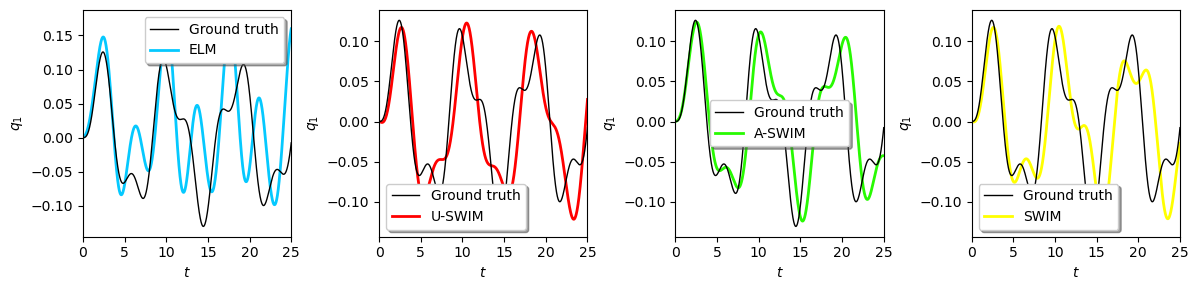

<Figure size 640x480 with 0 Axes>

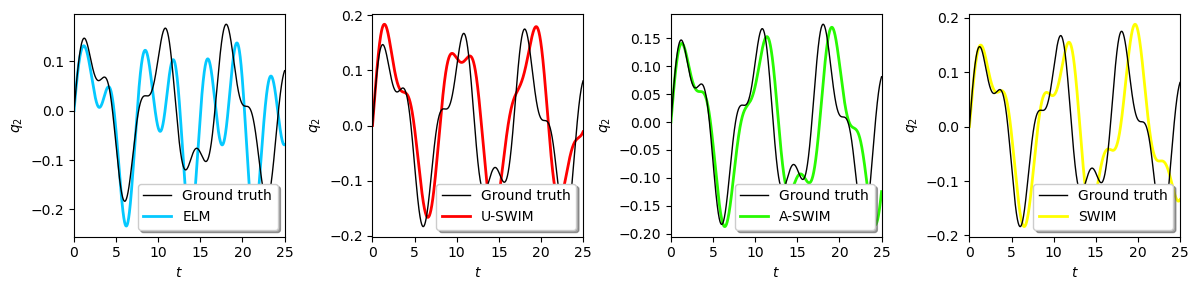

<Figure size 640x480 with 0 Axes>

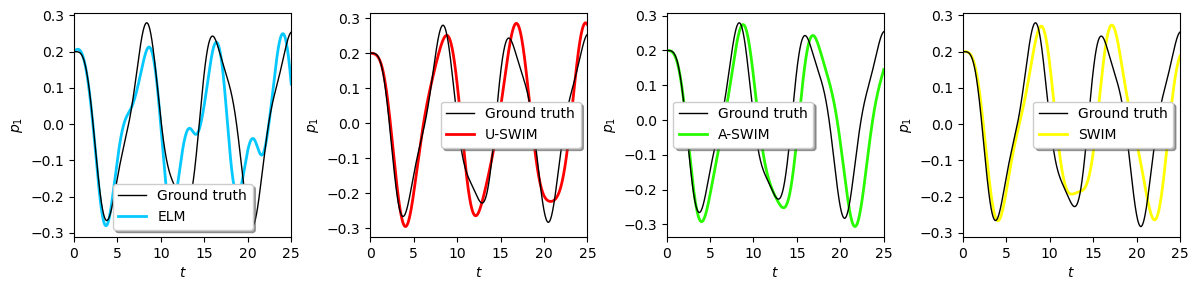

<Figure size 640x480 with 0 Axes>

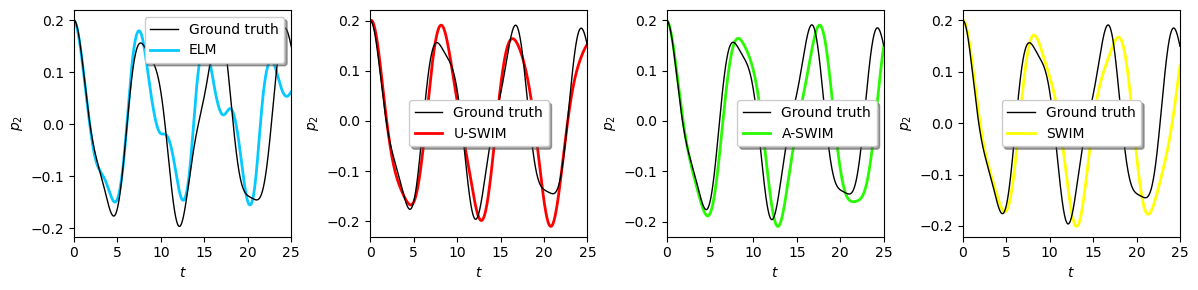

<Figure size 640x480 with 0 Axes>

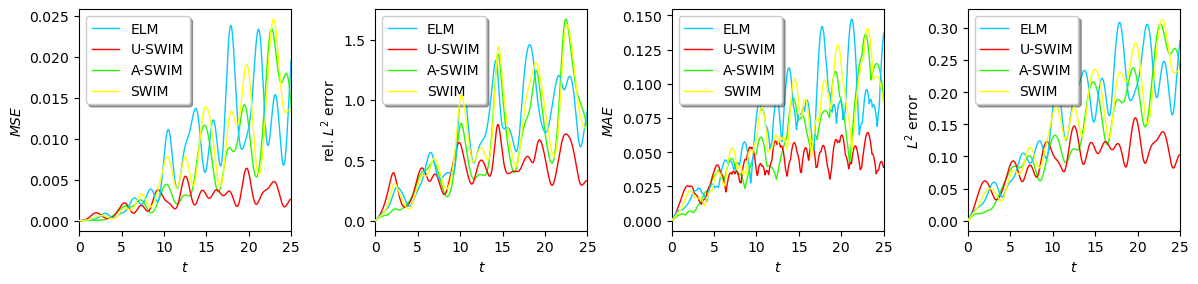

<Figure size 640x480 with 0 Axes>

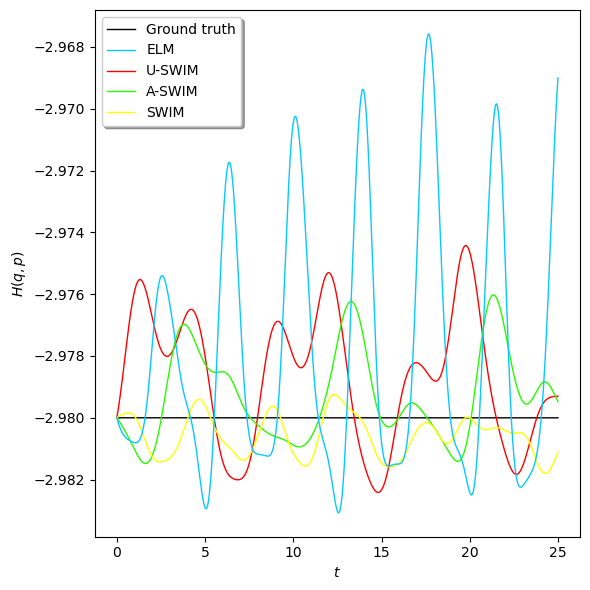

<Figure size 640x480 with 0 Axes>

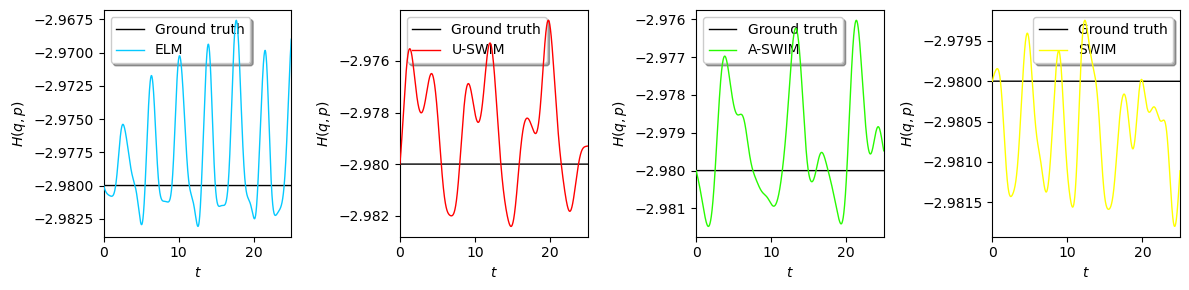

In [4]:
print(f"-> integrating ELM")
motion_pred_elm = solve_ivp(dt_pred_elm, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating USWIM")
motion_pred_uswim = solve_ivp(dt_pred_uswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating ASWIM")
motion_pred_aswim = solve_ivp(dt_pred_aswim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)
print(f"-> integrating SWIM")
motion_pred_swim = solve_ivp(dt_pred_swim, t_span, y0, dense_output=False, t_eval=t_eval, rtol=1e-8)

# get integrated trajectories of shape (N,2)
traj_true = motion_true.y.T
traj_pred_elm = motion_pred_elm.y.T
traj_pred_uswim = motion_pred_uswim.y.T
traj_pred_aswim = motion_pred_aswim.y.T
traj_pred_swim = motion_pred_swim.y.T

plot_predicted_trajectories_4d(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                               zorders=[2,1,1,1,1], linewidths=[1,2,2,2,2], verbose=True, 
                               save=['double_pendulum_predicted_integration_t_against_q1.pdf', 'double_pendulum_predicted_integration_t_against_q2.pdf', 'double_pendulum_predicted_integration_t_against_p1.pdf', 'double_pendulum_predicted_integration_t_against_p2.pdf'])



plot_predicted_trajectory_errors(t_span, t_eval, traj_true, traj_pred_elm, traj_pred_uswim, traj_pred_aswim, traj_pred_swim, 
                                zorders=[5,4,3,8], linewidths=[1,1,1,1], verbose=True, save='double_pendulum_predicted_integration_errors.pdf')

# true energies at the predicted trajectories
energy_true = H(traj_true)
energy_elm = H(traj_pred_elm)
energy_uswim = H(traj_pred_uswim)
energy_aswim = H(traj_pred_aswim)
energy_swim = H(traj_pred_swim)

plot_predicted_trajectory_energy(t_span, t_eval, energy_true, energy_elm, energy_uswim, energy_aswim, energy_swim, 
                                 zorders=[2,14,7,8,9], linewidths=[1,1,1,1,1], verbose=True, save='double_pendulum_integration_energies.pdf')